In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Training samples: (1052, 60, 4), Test samples: (264, 60, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 31,302
Trainable params: 31,302
Non-trainable params: 0
__________________________________________________________

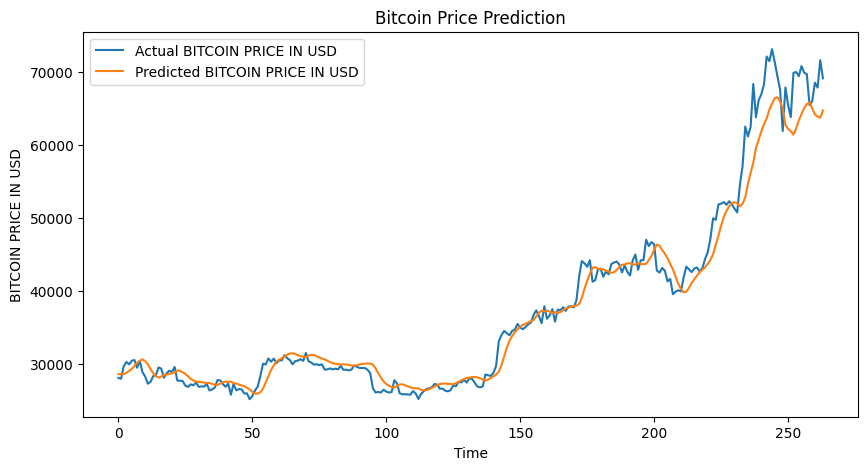

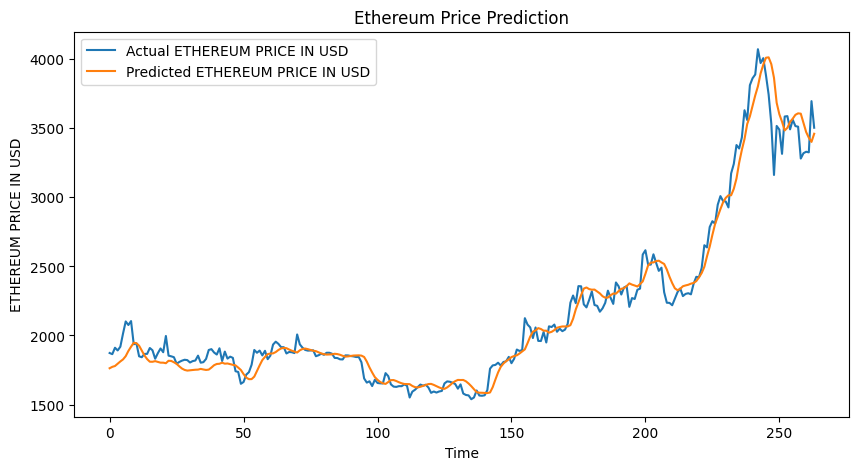

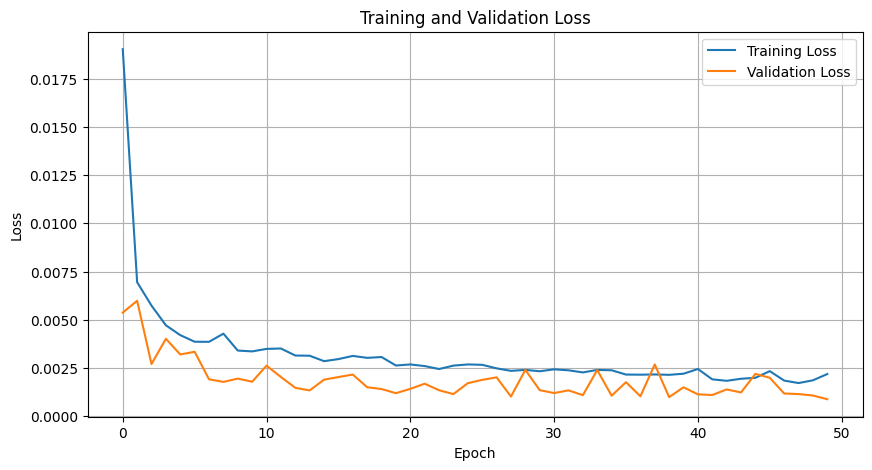

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(DataCapstone[features])

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum prices as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(2)  # Predict Bitcoin and Ethereum prices only
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

# Compare predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 0], label='Actual BITCOIN PRICE IN USD')
plt.plot(predictions_inv[:, 0], label='Predicted BITCOIN PRICE IN USD')
plt.legend()
plt.xlabel('Time')
plt.ylabel('BITCOIN PRICE IN USD')
plt.title('Bitcoin Price Prediction')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:, 1], label='Actual ETHEREUM PRICE IN USD')
plt.plot(predictions_inv[:, 1], label='Predicted ETHEREUM PRICE IN USD')
plt.legend()
plt.xlabel('Time')
plt.ylabel('ETHEREUM PRICE IN USD')
plt.title('Ethereum Price Prediction')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

In [3]:
# Calculate evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

btc_actual = y_test_inv[:, 0]
eth_actual = y_test_inv[:, 1]
btc_predictions = predictions_inv[:, 0]
eth_predictions = predictions_inv[:, 1]

btc_mae = mean_absolute_error(btc_actual, btc_predictions)
btc_mape = mean_absolute_percentage_error(btc_actual, btc_predictions)
btc_r2 = r2_score(btc_actual, btc_predictions)

eth_mae = mean_absolute_error(eth_actual, eth_predictions)
eth_mape = mean_absolute_percentage_error(eth_actual, eth_predictions)
eth_r2 = r2_score(eth_actual, eth_predictions)

# Print evaluation metrics
print("\nBitcoin Prediction Metrics:")
print(f"Mean Absolute Error: {btc_mae}")
print(f"Mean Absolute Percentage Error: {btc_mape}%")
print(f"R-squared Score: {btc_r2}")

print("\nEthereum Prediction Metrics:")
print(f"Mean Absolute Error: {eth_mae}")
print(f"Mean Absolute Percentage Error: {eth_mape}%")
print(f"R-squared Score: {eth_r2}")


Bitcoin Prediction Metrics:
Mean Absolute Error: 1603.570341293642
Mean Absolute Percentage Error: 3.812944064504996%
R-squared Score: 0.96533203901794

Ethereum Prediction Metrics:
Mean Absolute Error: 73.91592785044377
Mean Absolute Percentage Error: 3.2652981838064927%
R-squared Score: 0.9679533653904642


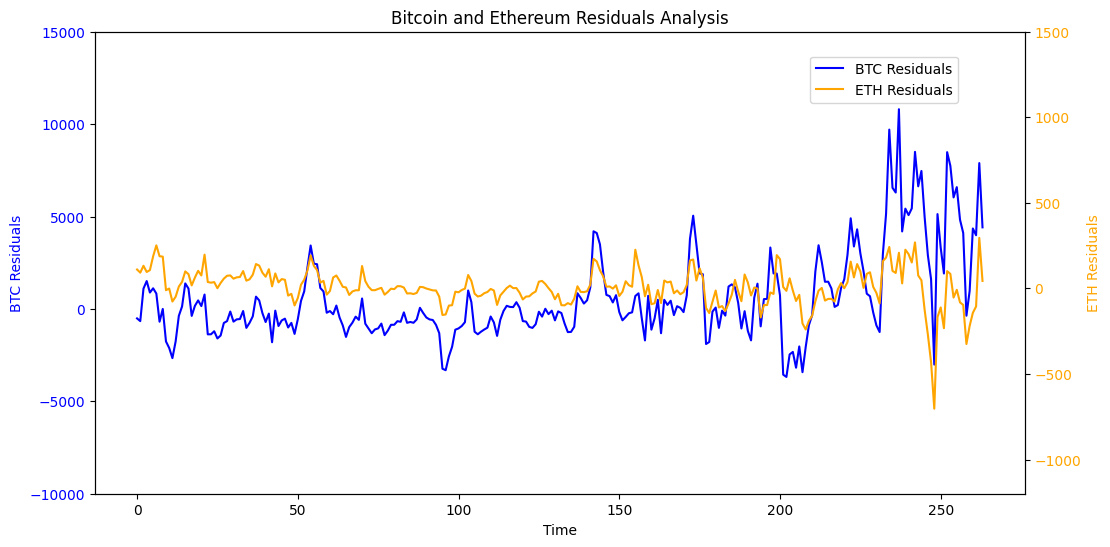

In [4]:
# Calculate residuals
residuals_btc = y_test_inv[:, 0] - predictions_inv[:, 0]
residuals_eth = y_test_inv[:, 1] - predictions_inv[:, 1]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Bitcoin residuals on the primary y-axis
ax1.plot(residuals_btc, label='BTC Residuals', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('BTC Residuals', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Set y-limits for Bitcoin residuals
ax1.set_ylim(-10000, 15000)

# Create a secondary y-axis and plot Ethereum residuals
ax2 = ax1.twinx()
ax2.plot(residuals_eth, label='ETH Residuals', color='orange')
ax2.set_ylabel('ETH Residuals', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set y-limits for Ethereum residuals
ax2.set_ylim(-1200, 1500)

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))

# Add title
plt.title('Bitcoin and Ethereum Residuals Analysis')

# Show plot
plt.show()

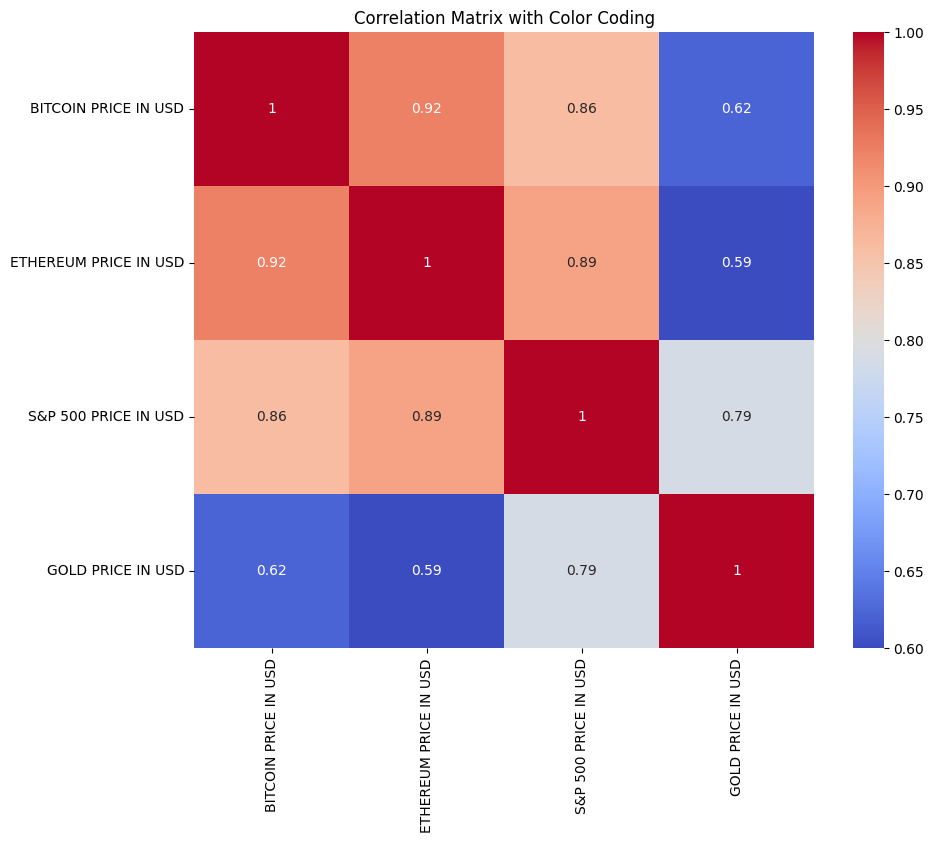

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame named 'DataCapstone'
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',')

# Convert the 'Date' column to datetime if applicable and set it as the index
DataCapstone['Date'] = pd.to_datetime(DataCapstone['Date'], dayfirst=True)
DataCapstone.set_index('Date', inplace=True)

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Filter the DataFrame to only include the relevant features
selected_data = DataCapstone[features]

# Calculate the correlation matrix
corr_matrix = selected_data.corr()

# Visualize Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0.6, vmax=1)
plt.title("Correlation Matrix with Color Coding")
plt.show()

Training samples: (1052, 60, 4), Test samples: (264, 60, 4)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            17664     
                                                                 
 dropout_2 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,818
Trainable params: 50,818
Non-trainable params: 0
________________________________________________________

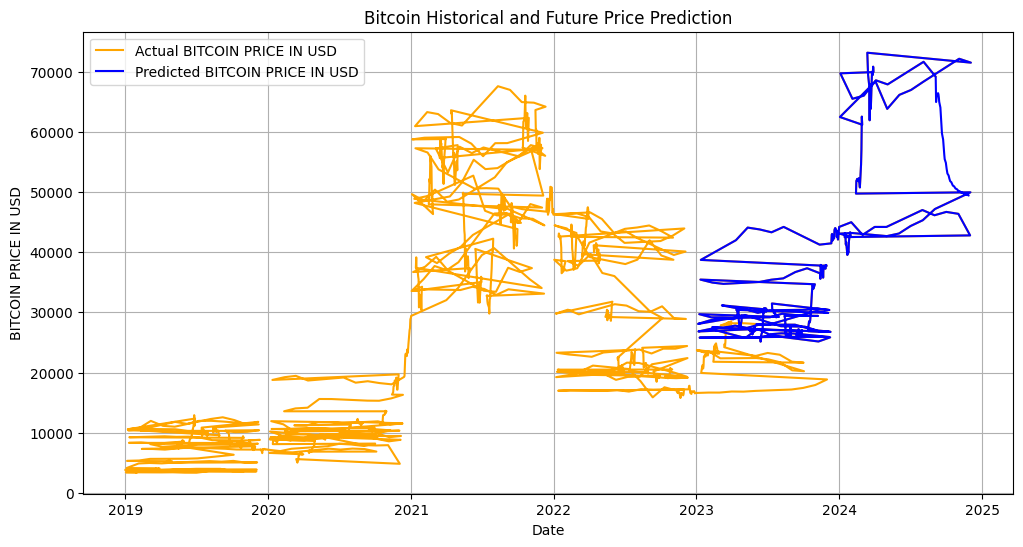

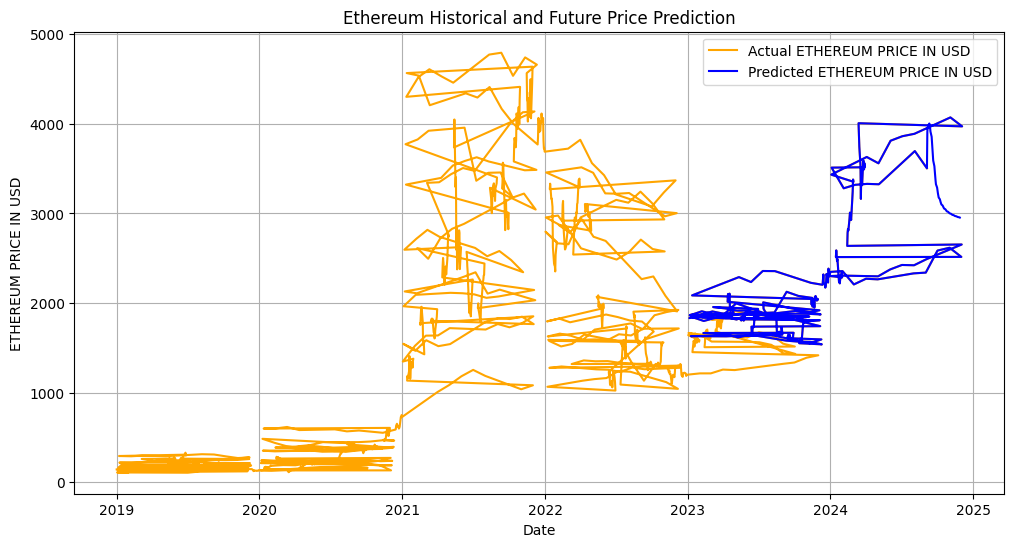

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the CSV file into a DataFrame
DataCapstone = pd.read_csv('DataCapstone.csv', delimiter=';', decimal=',', index_col='Date', parse_dates=True)

# Select relevant features using the given column names
btc_col = 'BITCOIN PRICE IN USD'
eth_col = 'ETHEREUM PRICE IN USD'
sp500_col = 'S&P 500 PRICE IN USD'
gold_col = 'GOLD PRICE IN USD'
features = [btc_col, eth_col, sp500_col, gold_col]

# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(DataCapstone[features])

# Convert to supervised format
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Only Bitcoin and Ethereum prices as targets
    return np.array(x), np.array(y)

# Define sequence length
SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {x_train.shape}, Test samples: {x_test.shape}")

# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(2)  # Predict Bitcoin and Ethereum prices only
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

# Predict on test data
predictions = model.predict(x_test)

# Inverse transform predictions and actual values to their original scale
y_test_inv = scaler.inverse_transform(np.concatenate([y_test, np.zeros((len(y_test), len(features) - 2))], axis=1))[:, :2]
predictions_inv = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), len(features) - 2))], axis=1))[:, :2]

# Function to predict future data
def predict_future(model, last_sequence, n_future, btc_eth_corr=0.92):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        full_prediction = np.concatenate([prediction, np.zeros((1, len(features) - 2))], axis=1)
        future_predictions.append(prediction[0])
        current_sequence = np.vstack([current_sequence[1:], full_prediction])
    
    future_predictions = np.array(future_predictions)

    # Adjust Ethereum prices based on the correlation with Bitcoin
    future_predictions[:, 1] = btc_eth_corr * future_predictions[:, 0]
    future_predictions[:, 1] = np.maximum(future_predictions[:, 1], 0)  # Ensure no negative Ethereum prices

    return future_predictions

# Predict the next 60 future values
last_sequence = x_test[-1]
n_future = 60
future_predictions = predict_future(model, last_sequence, n_future)

# Inverse transform future predictions to the original scale
future_predictions_inv = scaler.inverse_transform(np.concatenate([future_predictions, np.zeros((len(future_predictions), len(features) - 2))], axis=1))[:, :2]

# Generate date range for future predictions
last_date = DataCapstone.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='B')[1:]  # Use business days

# Combine historical and future data for Bitcoin predictions
bitcoin_full_dates = np.concatenate([DataCapstone.index[-len(y_test_inv):].values, future_dates])
bitcoin_full_predictions = np.concatenate([y_test_inv[:, 0], future_predictions_inv[:, 0]])

# Combine historical and future data pour Ethereum predictions
ethereum_full_dates = np.concatenate([DataCapstone.index[-len(y_test_inv):].values, future_dates])
ethereum_full_predictions = np.concatenate([y_test_inv[:, 1], future_predictions_inv[:, 1]])

# Plot future predictions vs historical data for Bitcoin
plt.figure(figsize=(12, 6))
plt.plot(DataCapstone.index, DataCapstone[btc_col], label='Actual BITCOIN PRICE IN USD', color='orange')
plt.plot(bitcoin_full_dates, bitcoin_full_predictions, label='Predicted BITCOIN PRICE IN USD', color='blue')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BITCOIN PRICE IN USD')
plt.title('Bitcoin Historical and Future Price Prediction')
plt.grid()
plt.show()

# Plot future predictions vs historical data for Ethereum
plt.figure(figsize=(12, 6))
plt.plot(DataCapstone.index, DataCapstone[eth_col], label='Actual ETHEREUM PRICE IN USD', color='orange')
plt.plot(ethereum_full_dates, ethereum_full_predictions, label='Predicted ETHEREUM PRICE IN USD', color='blue')
plt.legend()
plt.xlabel('Date')
plt.ylabel('ETHEREUM PRICE IN USD')
plt.title('Ethereum Historical and Future Price Prediction')
plt.grid()
plt.show()